<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Epidemiology 303</h1>
<h1>Meta-Population Model</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

from ipywidgets import interact

import epidemik
from epidemik import MetaEpiModel

import os
import gzip

import tqdm as tq
from tqdm.notebook import tqdm

import watermark

%load_ext watermark
%matplotlib inline

We start by printing out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.12.3

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Git hash: 23f2d9d21d6602f958f3826d7f8ed231a39b68e3

pandas    : 2.1.4
watermark : 2.4.3
epidemik  : 0.0.17
tqdm      : 4.66.2
matplotlib: 3.8.0
numpy     : 1.26.4



Load default figure style

In [3]:
plt.style.use('d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Airline Transportation Data

We will treat each of the lower 48 states as an individual population connected by flights. We start by loading the carrier data segment for 2019

In [4]:
data = pd.read_csv('data/336781026_T_T100D_SEGMENT_US_CARRIER_ONLY.zip',
                  usecols=[
                      'ORIGIN_STATE_ABR', 
                      'DEST_STATE_ABR', 
                      'PASSENGERS'],
                  dtype={'PASSENGERS':'float'})

Eas row corresponds to an individual flight

In [5]:
data

,PASSENGERS,ORIGIN_STATE_ABR,DEST_STATE_ABR
0,0.0,MA,MA
1,0.0,MA,MA
2,0.0,PA,IN
3,0.0,PA,TN
4,0.0,PA,TN
...,...,...,...
391109,83025.0,FL,GA
391110,83956.0,FL,GA
391111,85671.0,HI,HI
391112,85852.0,HI,HI


Rename the columns

In [6]:
data.rename(columns={'ORIGIN_STATE_ABR': 'Origin', 'DEST_STATE_ABR': 'Destination', 'PASSENGERS': 'Passengers'}, inplace=True)

And compute the totals for every pair of states

In [7]:
edges = data.groupby(['Origin', 
                      'Destination'], as_index=False).sum()
edges = edges[edges.Origin != edges.Destination].copy()

These are the totals for the entire year, so we divide by 365 to get the daily values.

In [8]:
edges['Passengers']/=365

We exclude self-loops, flights that start and end within the same state and cargo flights with no passengers

In [9]:
edges = edges[(edges.Origin != edges.Destination) & (edges.Passengers > 0)].copy()

In [10]:
edges

,Origin,Destination,Passengers
2,AK,AZ,76.906849
3,AK,CA,229.126027
4,AK,CO,194.241096
6,AK,GA,57.071233
7,AK,HI,196.720548
...,...,...,...
2166,WY,SD,1.413699
2167,WY,TN,0.038356
2168,WY,TX,217.580822
2169,WY,UT,423.635616


# Population data

Next we load the total population for each individual state.

In [11]:
populations = pd.read_csv('data/state_populations.csv', index_col=0)

In [12]:
populations

,State,Population
State_ABR,,
AL,Alabama,5024279
AR,Arkansas,3011524
AZ,Arizona,7151502
CA,California,39538223
CO,Colorado,5773714
CT,Connecticut,3605944
DE,Delaware,989948
FL,Florida,21538187
GA,Georgia,10711908


Extract the list of states from the index

In [13]:
states = list(populations.index)

Subset the states for which we have population data

In [14]:
edges48 = edges[(edges.Origin.map(lambda x: x in states)) & (edges.Destination.map(lambda x: x in states))]

Join the total population for each state to the flight connections dataset

In [15]:
edges48 = edges48.merge(populations[['Population']], left_on='Origin', right_index=True)

Normalize the number of passengers between every pair of states by the total population of the departure state to obtain a travel probability

In [16]:
edges48['Weight'] = edges48['Passengers'].div(edges48['Population'])

Finally, generate the travel matrix where element $m_{ij}$ is the travel probability between state $i$ and state $j$.

In [17]:
travel = pd.pivot_table(edges48, 
                        index='Origin', 
                        columns='Destination', 
                        values='Weight', 
                        aggfunc='sum')

travel = travel.fillna(0) + np.diag(1-travel.sum(axis=1))

In [18]:
travel

Destination,AL,AR,AZ,CA,CO,CT,DE,FL,GA,IA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
Origin,,,,,,,,,,,,,,,,,,,,,
AL,9.984235e-01,4.629575e-07,5.605657e-07,1.302715e-06,0.000071,3.762552e-08,0.000000e+00,1.151248e-04,0.000547,4.362379e-09,...,0.000000e+00,2.625607e-06,3.741132e-04,5.452974e-08,7.345155e-05,0.000000e+00,6.870747e-08,2.181189e-08,8.179460e-09,2.399308e-08
AR,5.158268e-07,9.980436e-01,3.169560e-05,5.127336e-05,0.000113,0.000000e+00,0.000000e+00,5.893889e-05,0.000383,0.000000e+00,...,0.000000e+00,6.335481e-06,7.101670e-04,1.746715e-07,3.464409e-05,0.000000e+00,0.000000e+00,6.732131e-08,0.000000e+00,3.911914e-08
AZ,7.654298e-07,1.288282e-05,9.909381e-01,2.216724e-03,0.000578,2.827263e-07,0.000000e+00,2.630558e-04,0.000256,6.885918e-05,...,3.779760e-05,8.486118e-05,1.113347e-03,2.963895e-04,8.723103e-05,0.000000e+00,4.633589e-04,9.681614e-05,6.780834e-08,1.775659e-06
CA,3.276871e-07,3.924623e-06,3.956321e-04,9.951478e-01,0.000356,2.421032e-06,2.771724e-10,1.668190e-04,0.000194,6.812205e-07,...,5.403476e-07,4.723489e-05,6.658014e-04,1.956386e-04,1.119136e-04,4.157586e-10,4.475436e-04,7.036299e-06,2.078793e-10,2.120022e-06
CO,6.149599e-05,5.928142e-05,7.225334e-04,2.493278e-03,0.984440,5.432936e-05,1.423551e-09,8.393325e-04,0.000468,1.293652e-04,...,1.082184e-04,2.767085e-04,1.885036e-03,4.366373e-04,4.324839e-04,7.340780e-06,5.859456e-04,2.087443e-04,0.000000e+00,1.390288e-04
CT,0.000000e+00,1.162464e-07,0.000000e+00,2.417926e-05,0.000088,9.975436e-01,0.000000e+00,6.900950e-04,0.000246,0.000000e+00,...,0.000000e+00,4.984160e-07,7.014674e-05,1.010508e-07,2.011101e-04,7.597805e-09,0.000000e+00,6.359363e-07,0.000000e+00,0.000000e+00
DE,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,9.999982e-01,6.697460e-07,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,2.241712e-07,0.000000e+00,8.302636e-09,5.535091e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
FL,2.631389e-05,8.235262e-06,8.438087e-05,3.043815e-04,0.000227,1.147220e-04,3.040156e-08,9.909871e-01,0.001159,1.742735e-05,...,3.380679e-06,2.197682e-04,9.216829e-04,4.819576e-05,3.864358e-04,9.919305e-07,4.806970e-05,5.937171e-05,1.033500e-05,4.350349e-08
GA,2.486719e-04,1.080733e-04,1.693826e-04,7.230547e-04,0.000254,8.310352e-05,0.000000e+00,2.313318e-03,0.987818,4.972651e-05,...,9.638742e-06,4.367054e-04,9.464134e-04,1.527917e-04,6.788295e-04,1.019733e-05,1.441517e-04,1.610015e-04,2.136324e-05,4.061796e-06


# Create the model

The __MetaEpiModel__ class takes the travel matrix and population data as inputs. Please note that the index of the population data must match the rows and column names for the travel matrix and the populations DataFrame must have a column named "Population"

In [19]:
model = MetaEpiModel(travel, populations)

We can add transitions just as we would for any other model

In [20]:
beta = 0.3
mu = 0.1

model.add_interaction('S', 'I', 'I', rate=beta)
model.add_spontaneous('I', 'R', rate=mu)

And obtain a summary, just as before

In [21]:
print(model)

Metapopulation model with 48 populations

The disease is defined by an Epidemic Model with 3 compartments and 2 transitions:

S + I = I 0.300000
I -> R 0.100000

R0=3.00


And to simulate the model we call the __simulate__ method. THe only difference is that we must specify the __seed_state__ and the initial populations in that state. For simplicity, the susceptible compartment is initialized using the population data and all other compartments are initialized to zero.

In [22]:
model.simulate(150, seed_state='NY', I=10)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 51.23it/s]


After the simulation, the final compartment populations for each state can be found in the __compartments____ field

In [23]:
model.compartments_

,S,I,R
State_ABR,,,
AL,271996,0,4750651
AR,162663,1,2845665
AZ,388125,1,6760956
CA,2141151,0,37401497
CO,315227,0,5460453
CT,196747,0,3407385
DE,53114,15,936812
FL,1199574,1,20341670
GA,595937,0,10125969


The results for each state can be found in the __models__ field, indexed by the state name

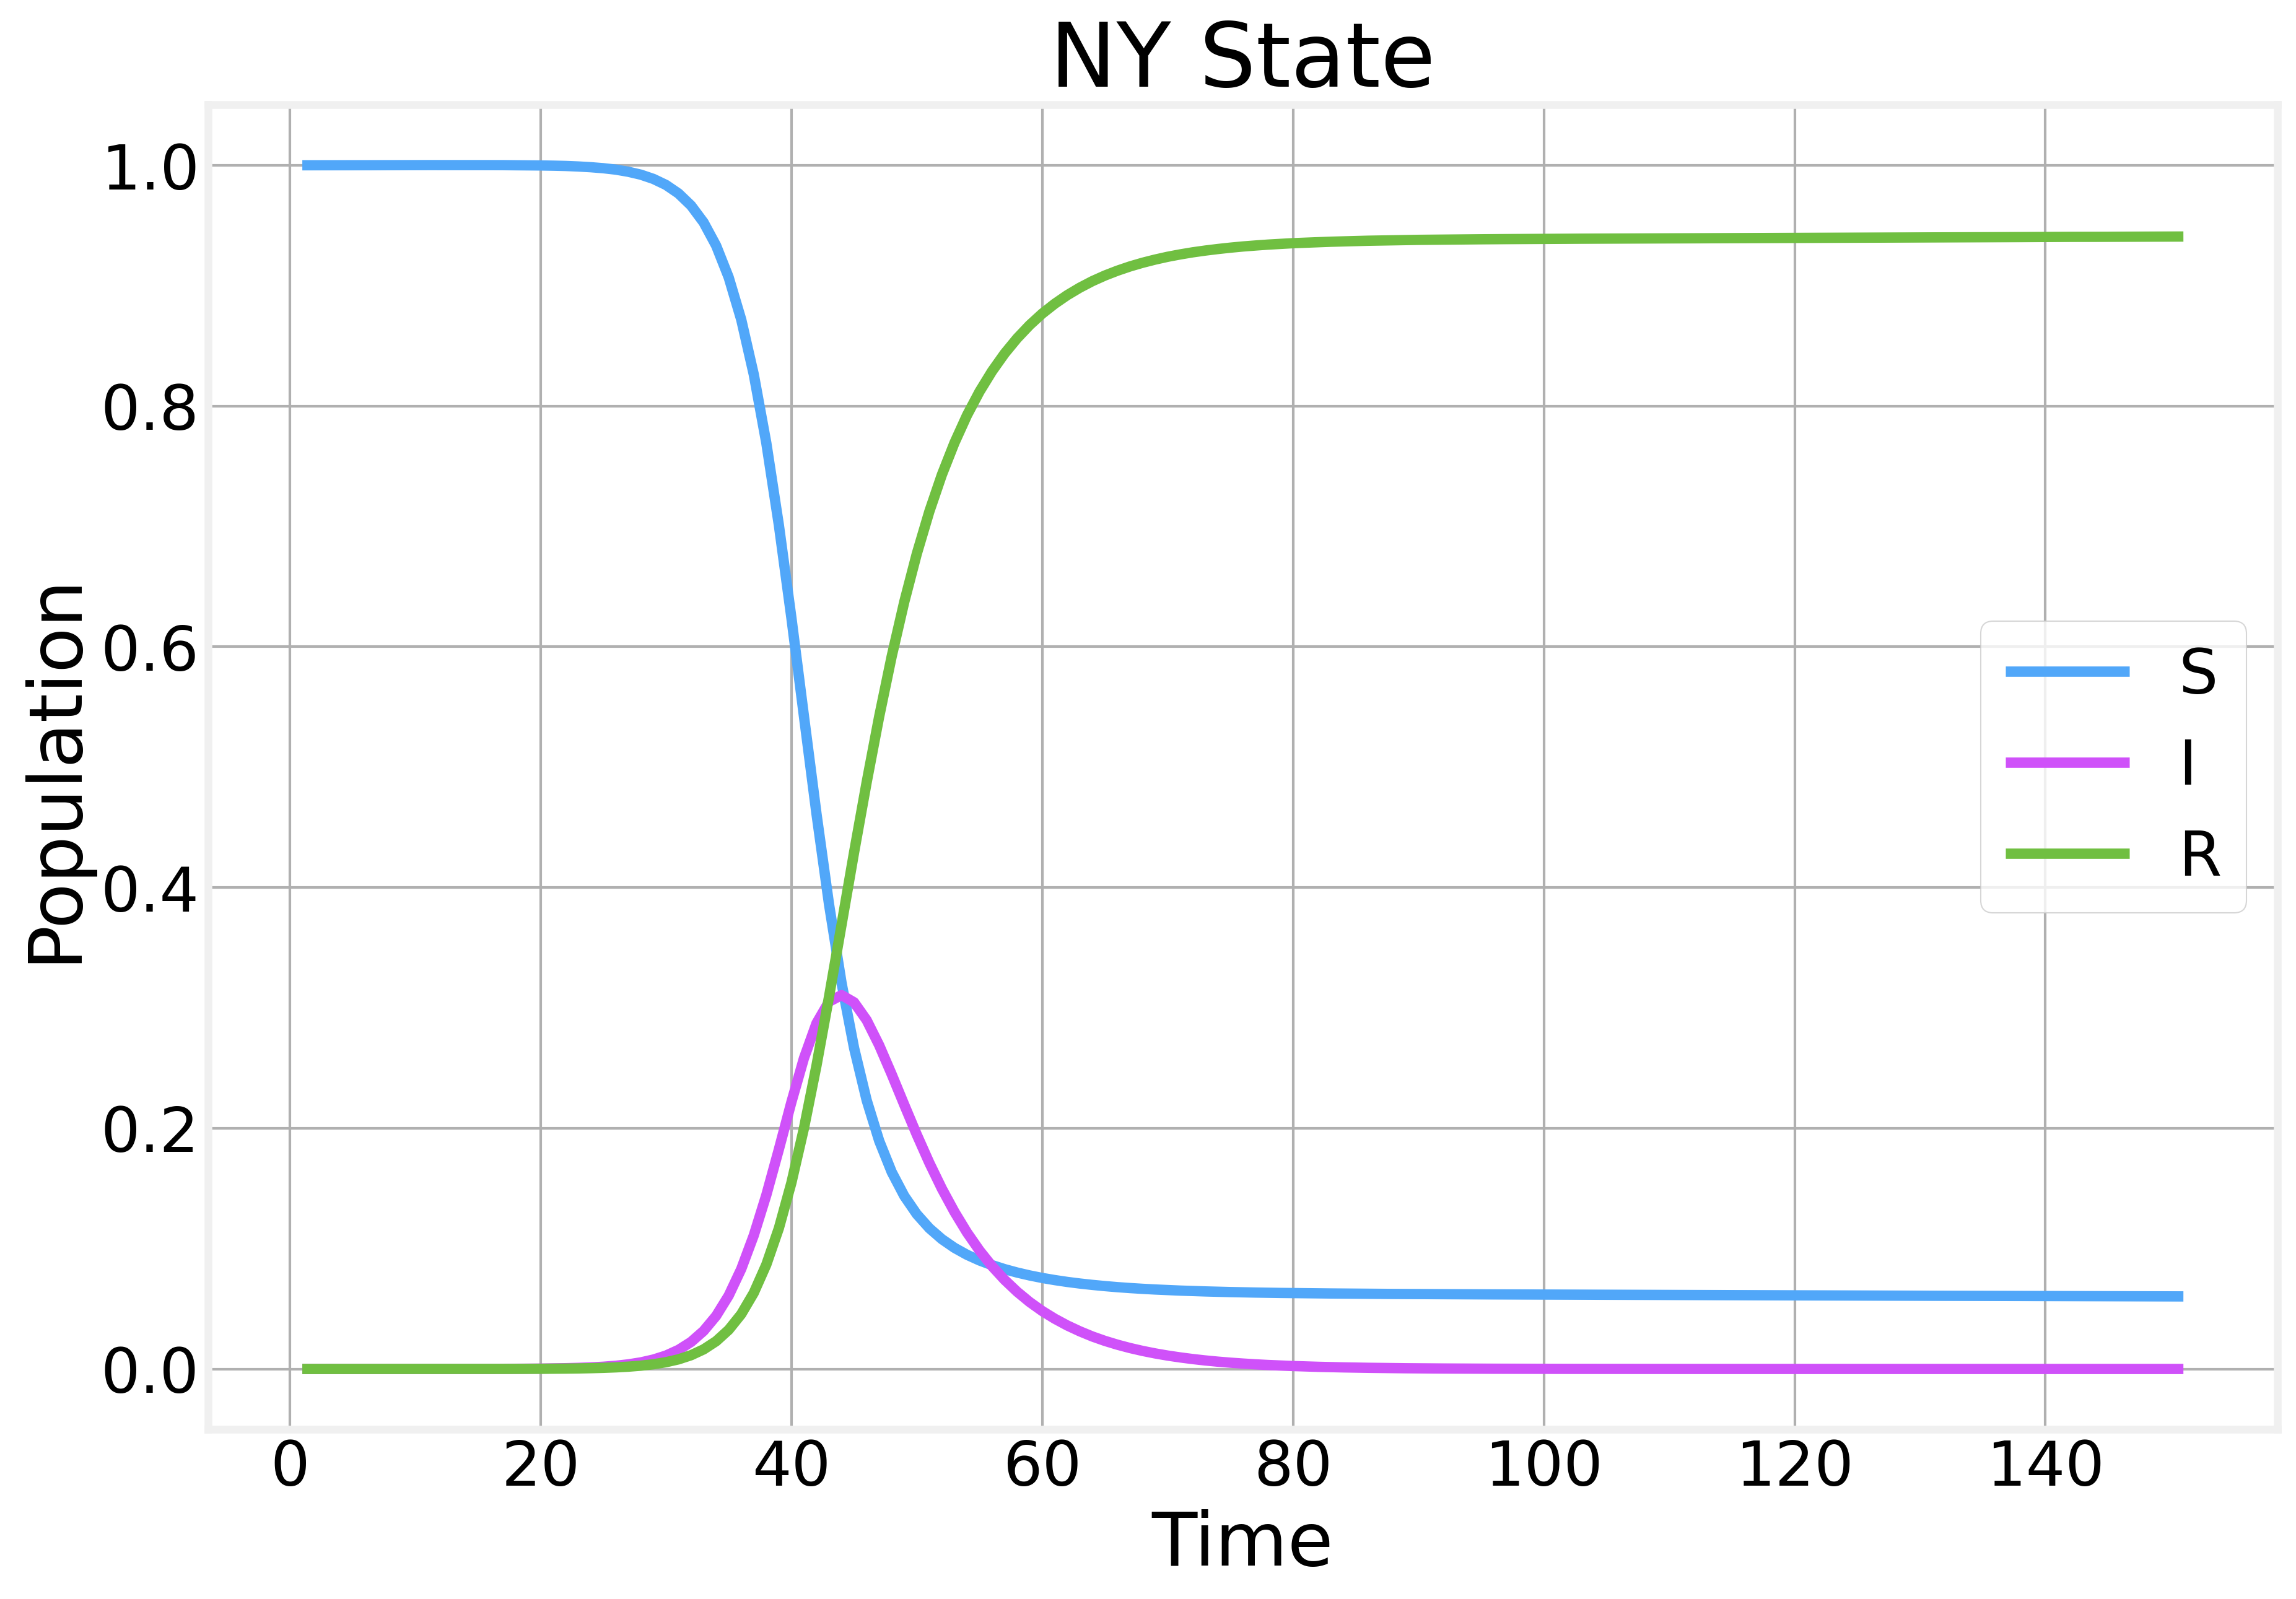

In [24]:
ax = model.models['NY'].plot(title='NY State')

And we can see the effect of the travel matrix by comparing the fraction of infected population for states that are close to each other. 

Text(0, 0.5, 'Population')

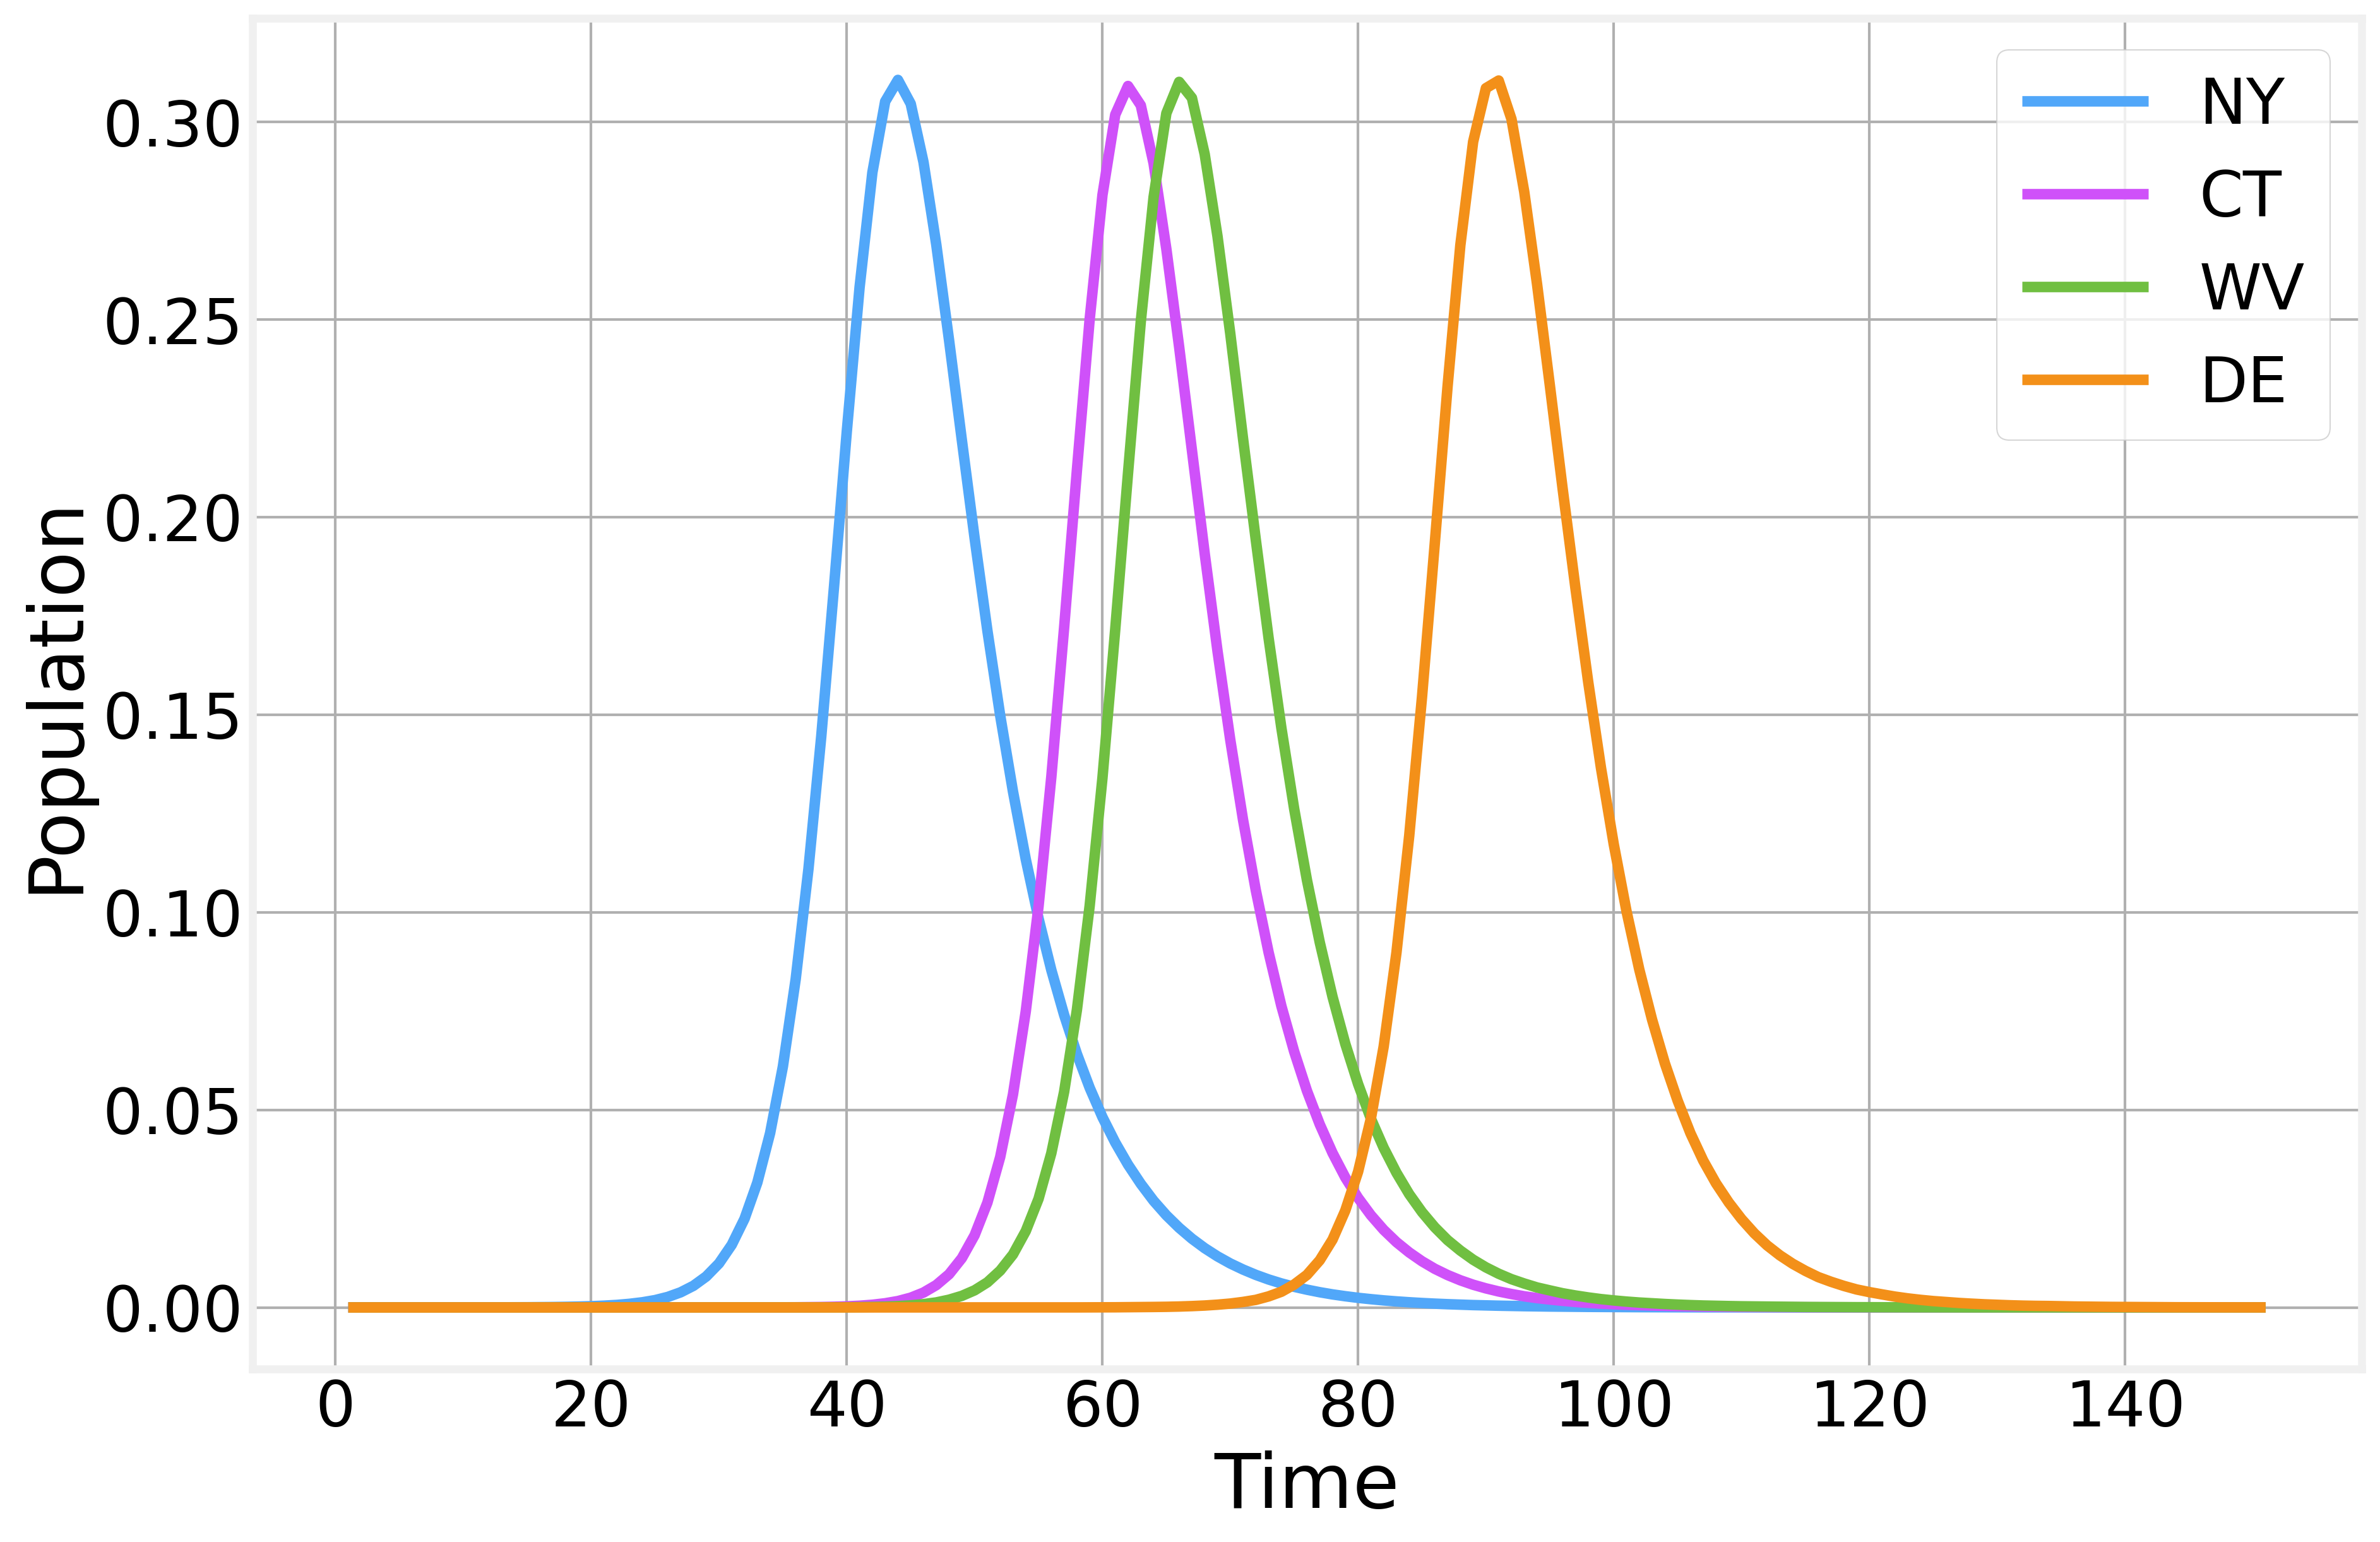

In [25]:
ax = (model.models['NY']['I']/model.populations.loc['NY', 'Population']).plot(label='NY')
(model.models['CT']['I']/model.populations.loc['CT', 'Population']).plot(ax=ax, label='CT')
(model.models['WV']['I']/model.populations.loc['WV', 'Population']).plot(ax=ax, label='WV')
(model.models['DE']['I']/model.populations.loc['DE', 'Population']).plot(ax=ax, label='DE')

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Population')

with the epidmic peaks occurring in the order of the ravel intensity between the two states

In [26]:
travel.loc[['NY']][['DE', 'CT', 'WV']].T.sort_values(by='NY', ascending=False)

Origin,NY
Destination,
CT,1.803767e-07
WV,4.801005e-08
DE,1.763081e-09


Finally, we can plot the entire history of the epidemic using the plot method. For clarity, we provide a manual layout for the state positions

In [27]:
state_coords = pd.read_csv('data/states.csv', index_col=0)

In [28]:
seeding = [(state, 
            model.models[state]['I'][model.models[state]['I']>0].index.min(),
            travel.loc['NY', state]
           ) for state in model.models.keys() if state != 'NY']

In [29]:
seeding = pd.DataFrame(seeding, columns=['state', 'seeding', 'travel'])

Text(0, 0.5, 'Traveling Probability')

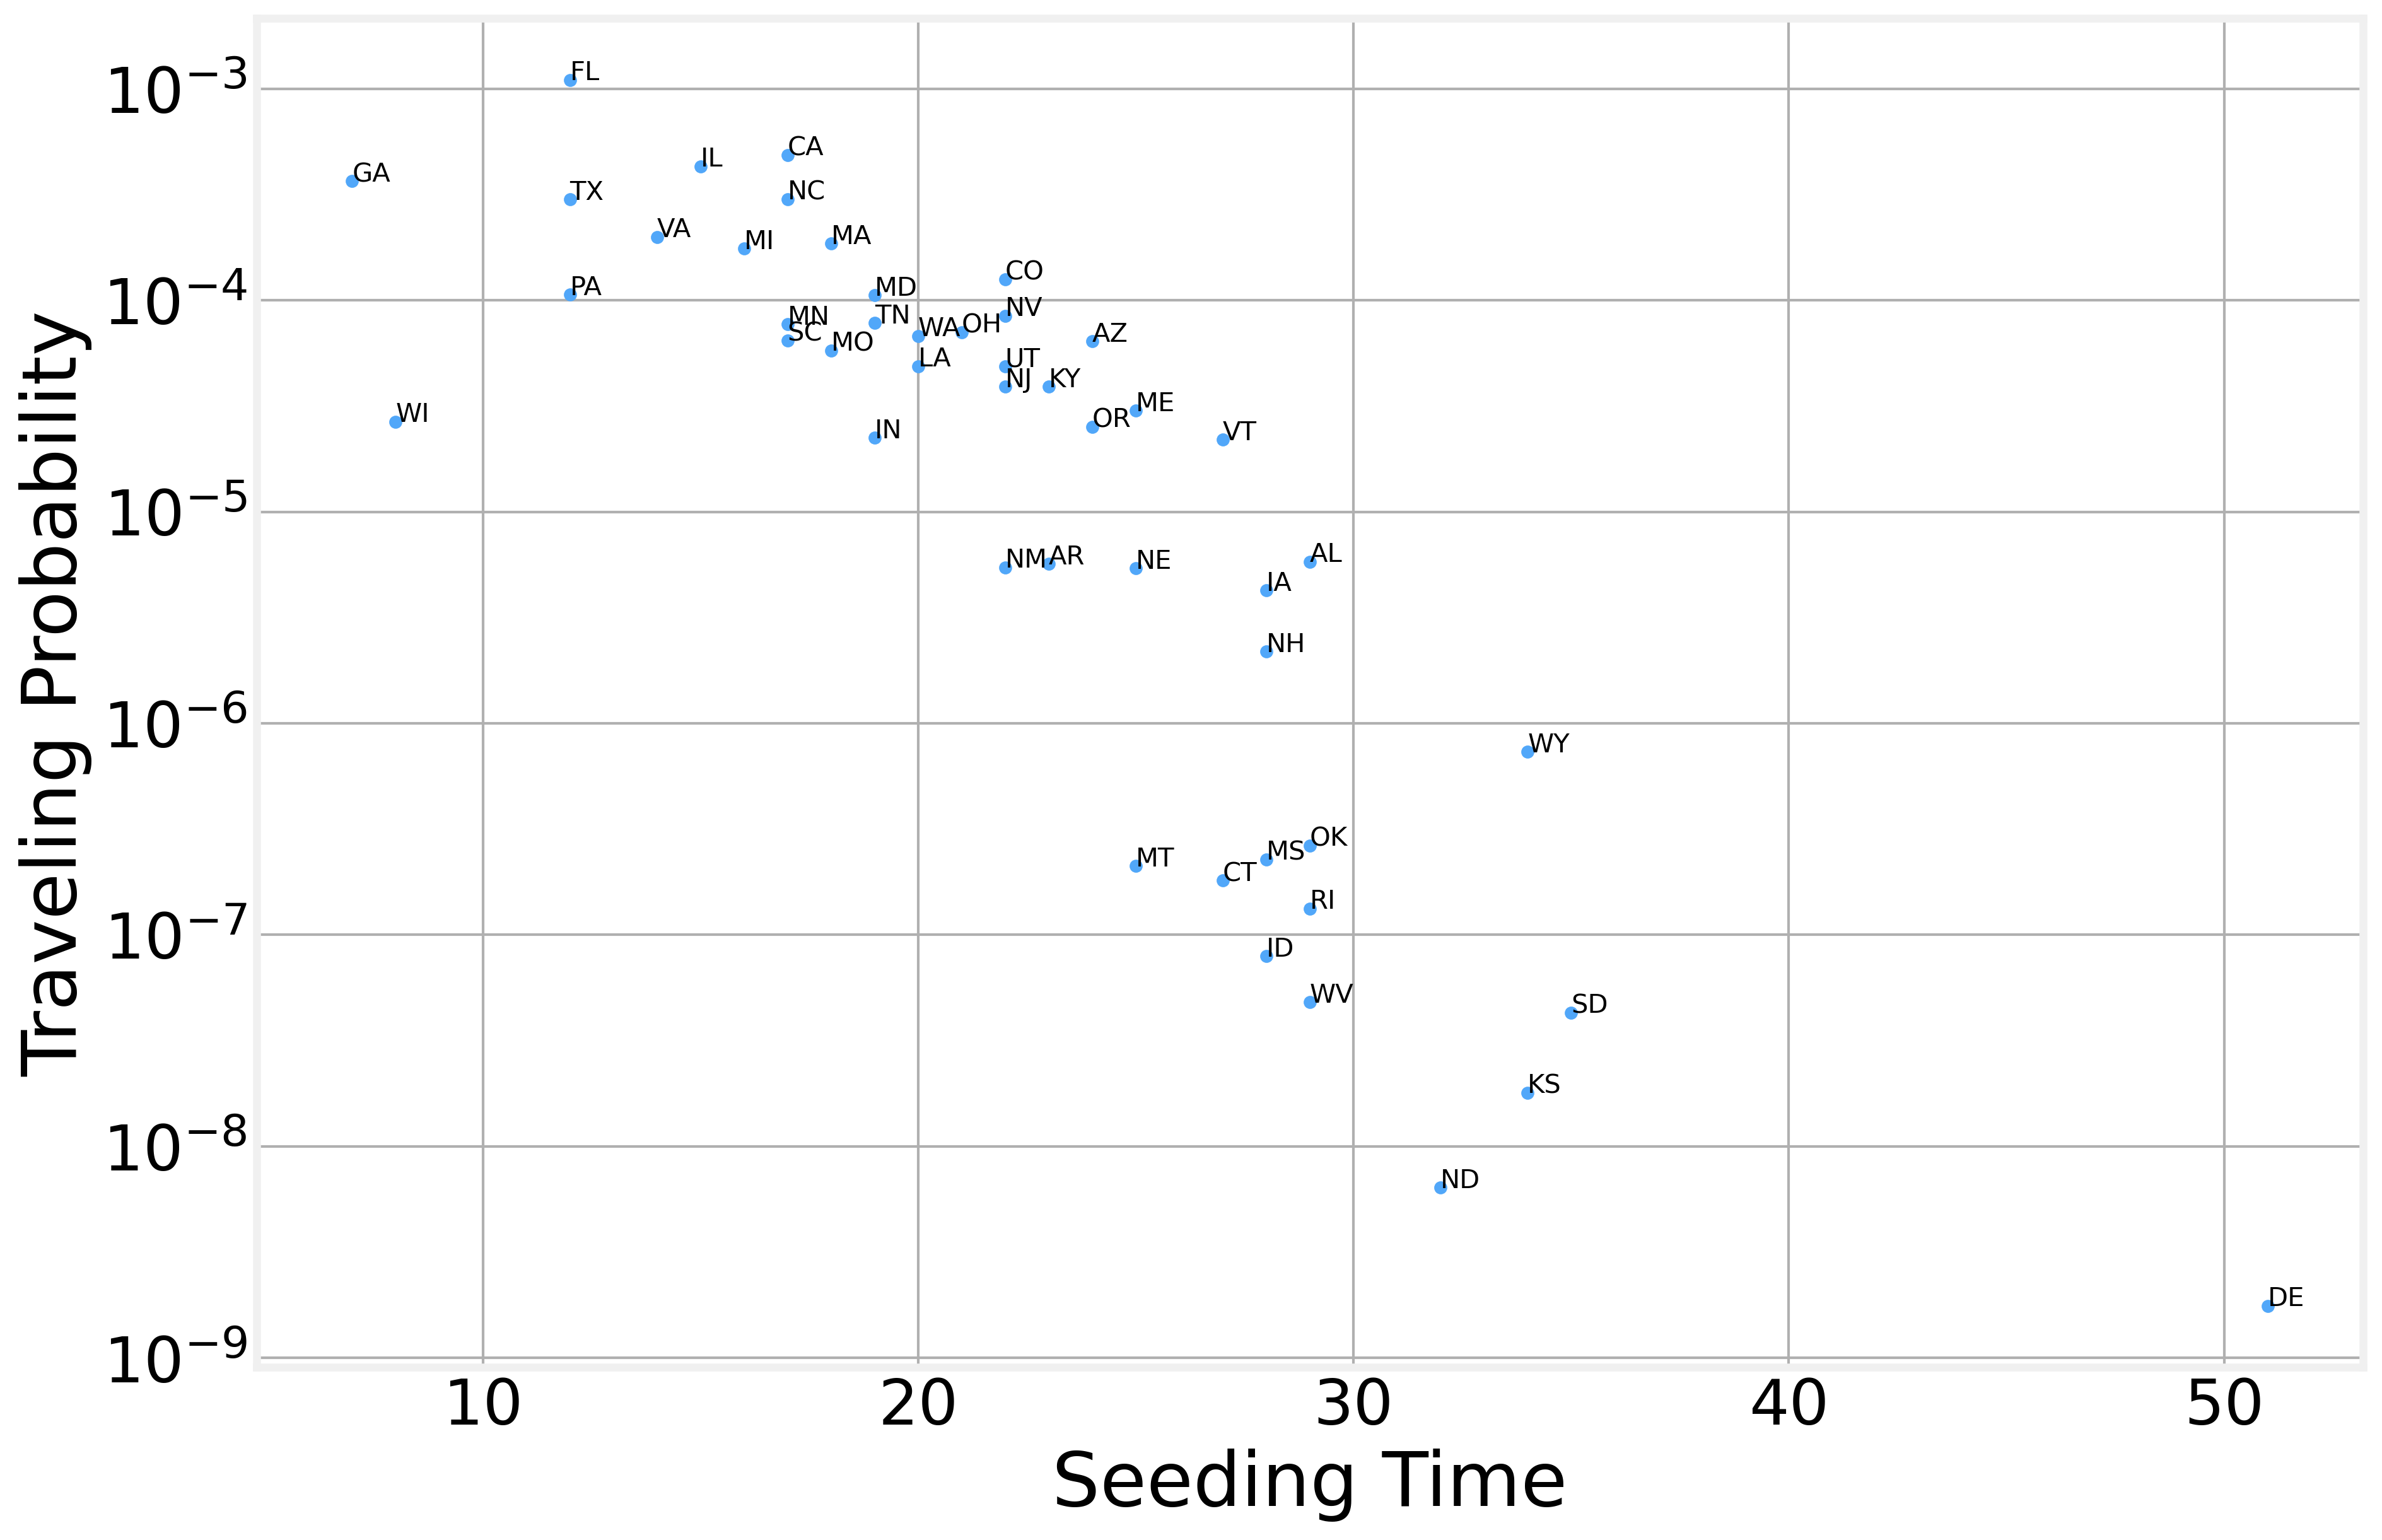

In [30]:
ax = seeding.plot.scatter(x='seeding', y='travel')
seeding.apply(lambda x: ax.text(x=x.seeding, y=x.travel, s=x.state, fontsize=10), axis=1)
ax.set_yscale('log')
ax.set_xlabel('Seeding Time')
ax.set_ylabel('Traveling Probability')

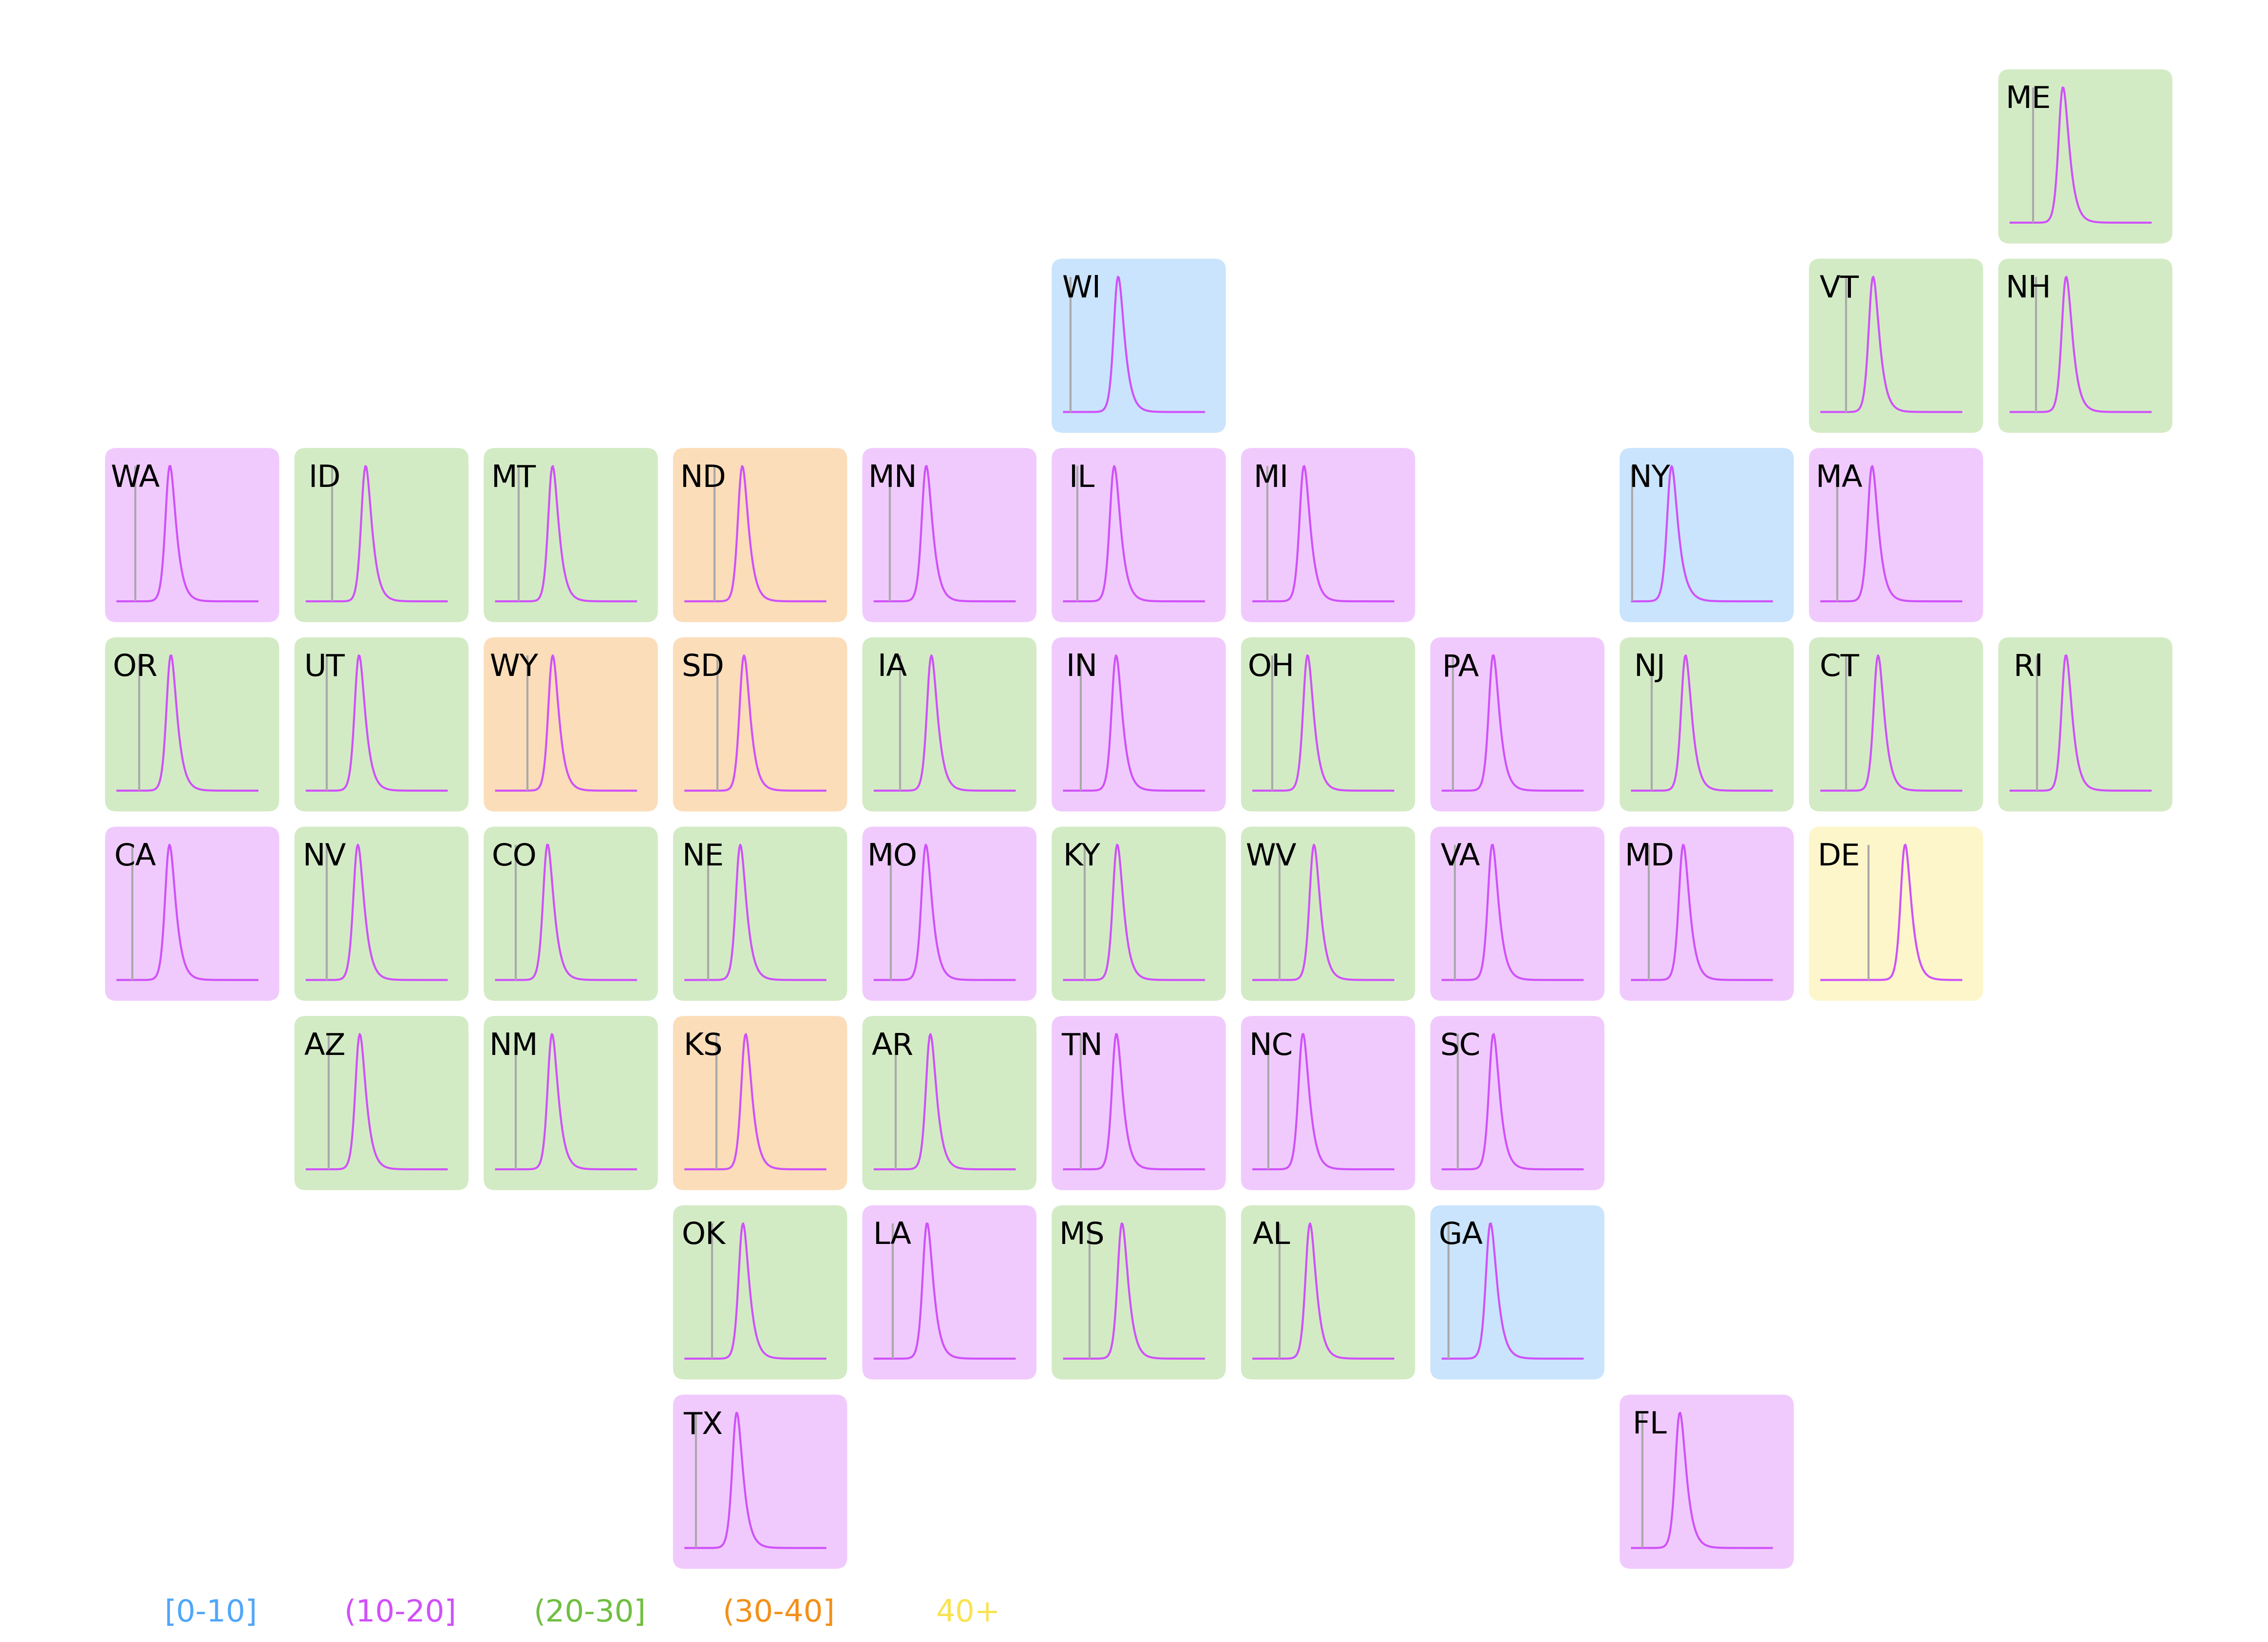

In [31]:
model.plot(layout=state_coords)

The vertical line in each state represents the date of the first infectious case, as does the color of the state.

If we didn't provide a layout, the results would just be plotted in a grid.

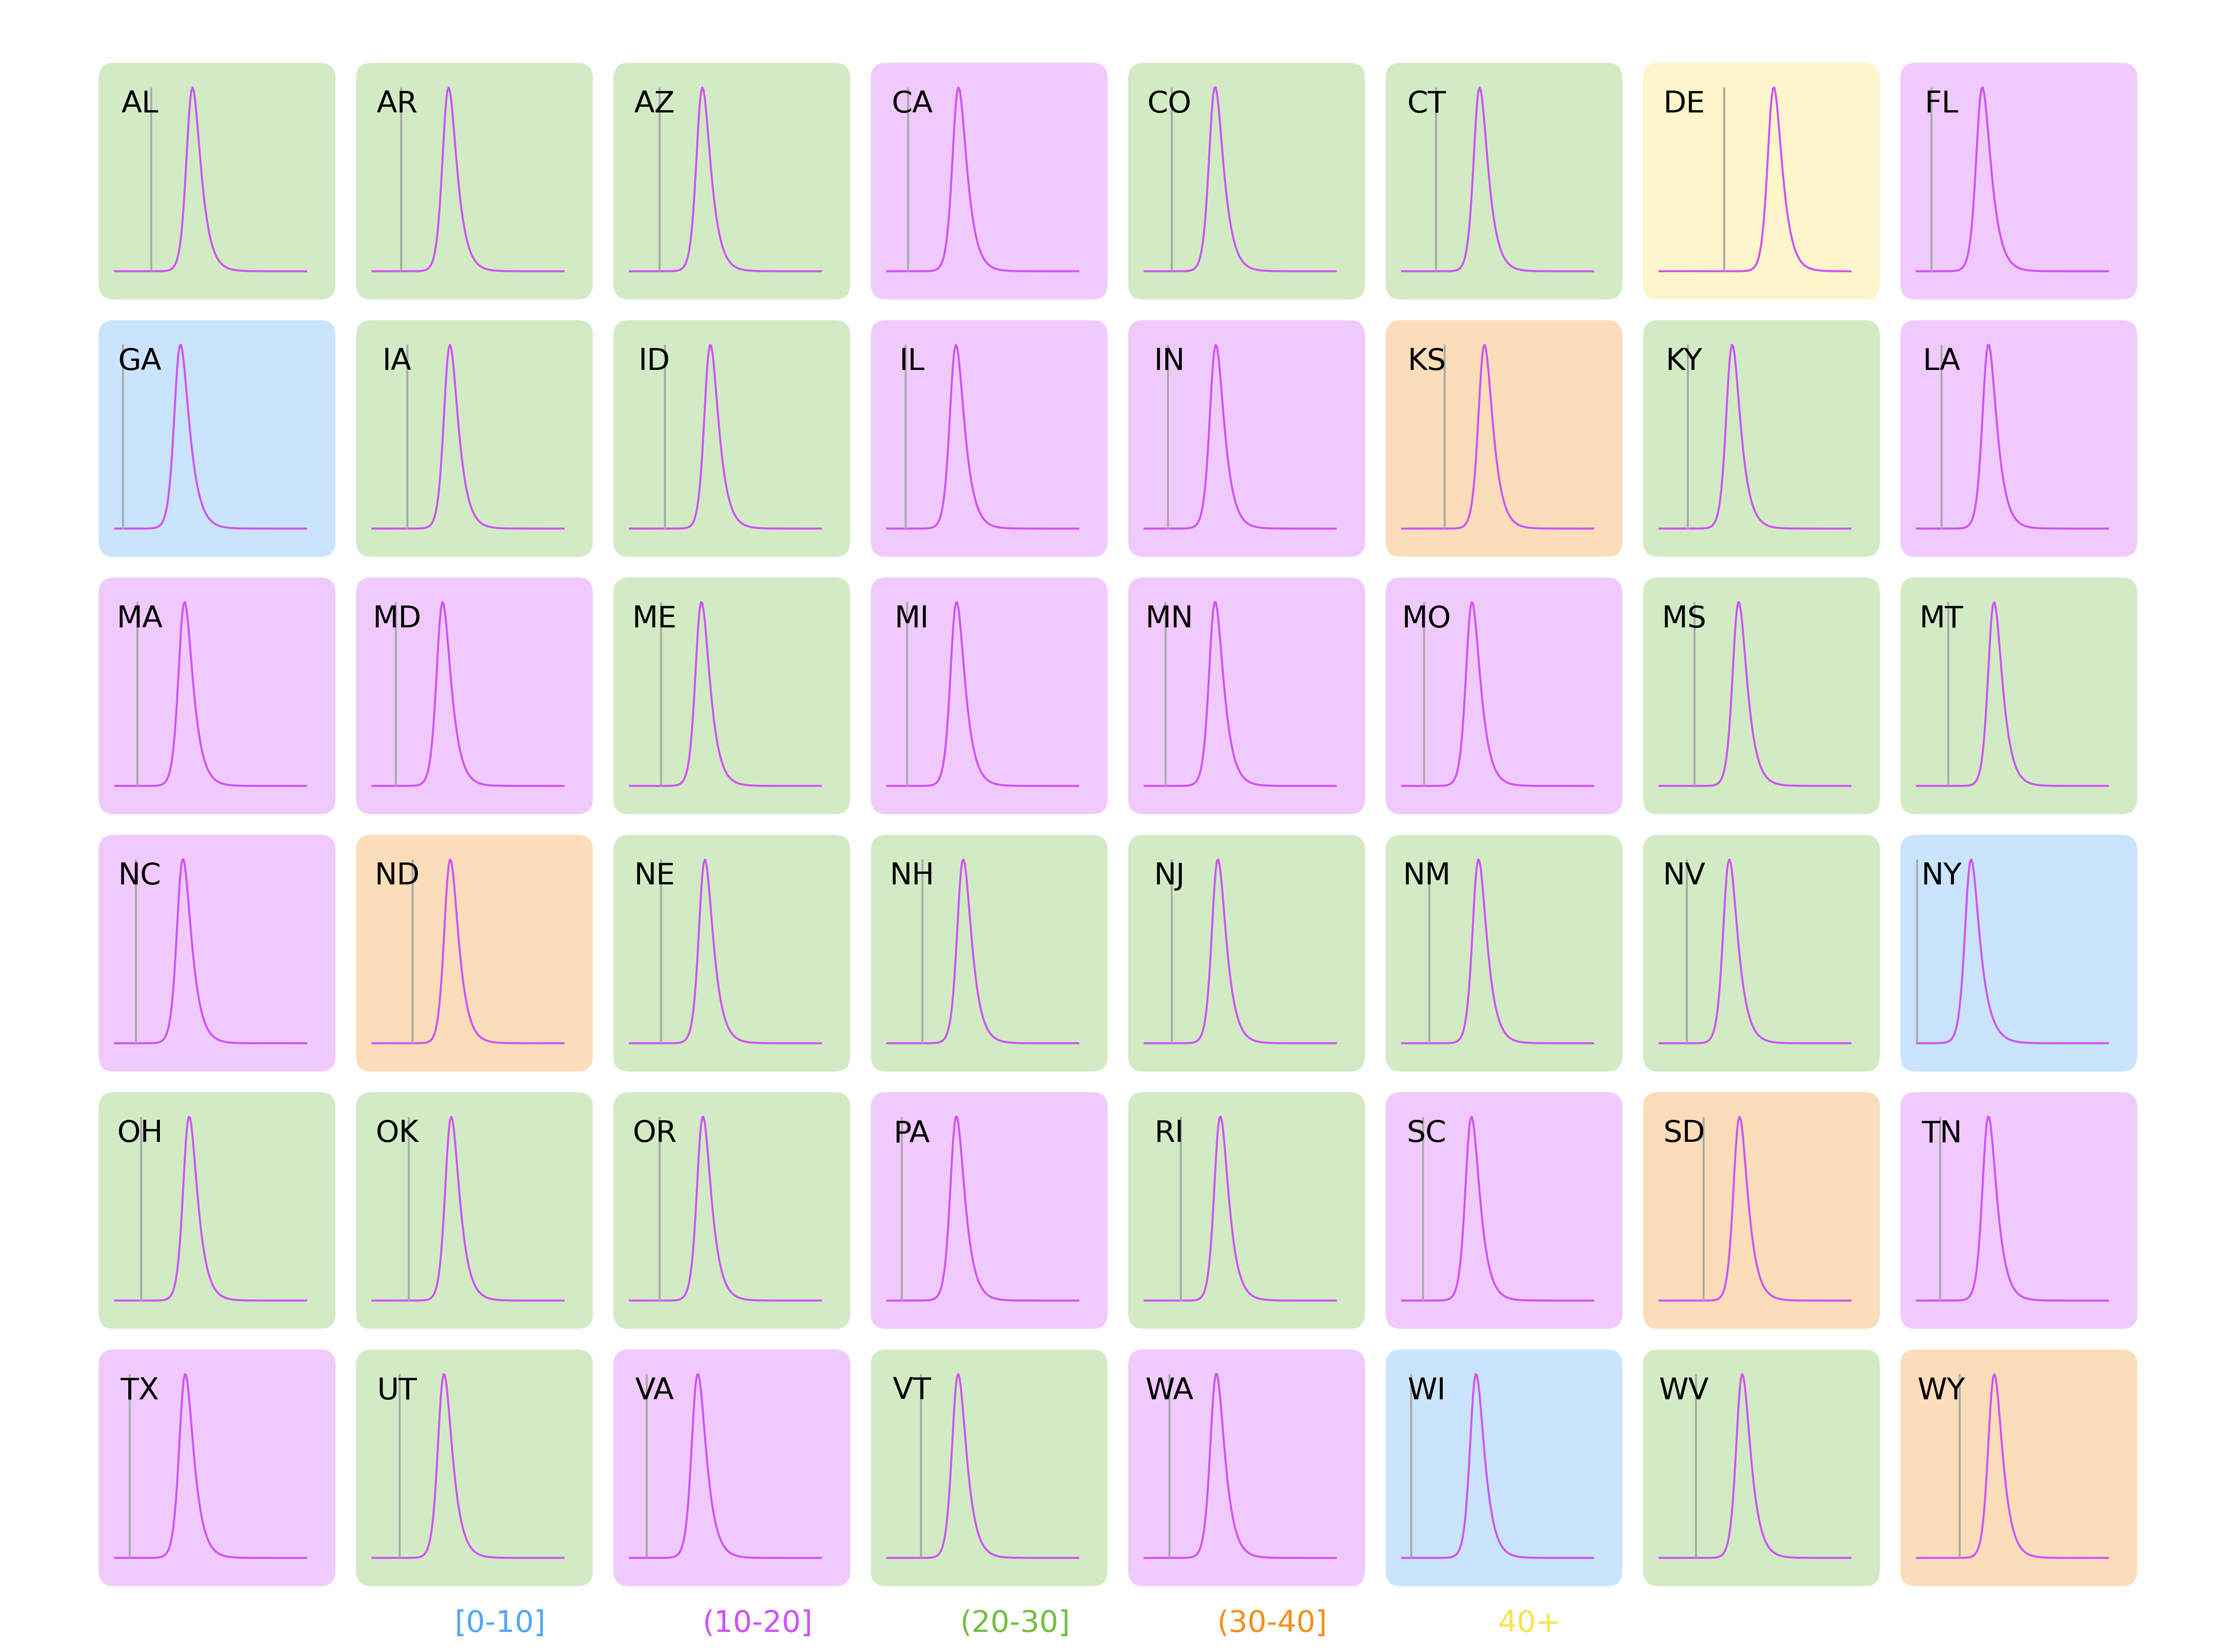

In [32]:
model.plot()

<center>
     <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</center>